In [1]:
import numpy as np
import sympy as smp
from sympy import hermite as H


x, y, z, w0, k, z0 = smp.symbols('x y z omega_0 k z_0', real = True)
m, p = smp.symbols('m p', integer = True, positive = True)
w, R = smp.symbols('omega R', cls = smp.Function)
w = w(z)
R = R(z)


E_x = H(m, smp.sqrt(2)*x / w)*H(p, smp.sqrt(2)*y / w)* w0/w * smp.exp(- (x**2 + y**2) / w**2) * smp.exp(smp.I*(k*z + (1 + m + p) * smp.atan2(z, z0))) * smp.exp(smp.I * k * (x**2 + y**2) / (2*R))

E_x = E_x.subs([(w, w0*smp.sqrt(1 + (z/z0)**2)), (R, z*(1 + (z0/z)**2))])

E_y = 0

E_z = smp.I/k * smp.diff(E_x, x).simplify()


iw_B_x = smp.diff(E_z, y) - smp.diff(E_y, z)

iw_B_y = -smp.diff(E_z, x) + smp.diff(E_x, z)

iw_B_z = smp.diff(E_y, x) - smp.diff(E_x, y)


E_x_f = smp.lambdify([m, p, z0, w0, k,  x, y, z], E_x)
E_y_f = smp.lambdify([m, p, z0, w0, k,  x, y, z], E_y)
E_z_f = smp.lambdify([m, p, z0, w0, k,  x, y, z], E_z)

iw_B_x_f = smp.lambdify([m, p, z0, w0, k,  x, y, z], iw_B_x)
iw_B_y_f = smp.lambdify([m, p, z0, w0, k,  x, y, z], iw_B_y)
iw_B_z_f = smp.lambdify([m, p, z0, w0, k,  x, y, z], iw_B_z)

In [2]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [21]:
c = 137 # v0 (viteze atomice) ------- viteza luminii in vid
alpha = 1/137.036
la = 0.75 #micrometru----------lungimea de unda pt rosu
w_0 = 50*la #micrometru --------- largimea fasciculului
k = 2*np.pi/la # 1/micrometru------ modulul vectorului de unda in directia z
w = c * k
z_0 = np.pi*w_0**2 / la #micrometru-------distanta_Rayleigh
K = 1e-13*3e8/1e-6

In [22]:
def field(t, r, m, p):
    """
    Function that returns
    (E, B) at time t at point r
    r = (x[0], x[1], x[2])
    m, p integers greater than zero
    """
    E = []; B = []
    
    E.append(E_x_f(m, p, z_0, w_0, k, r[0], r[1], r[2]))
    E.append(E_y_f(m, p, z_0, w_0, k, r[0], r[1], r[2]))
    E.append(E_z_f(m, p, z_0, w_0, k, r[0], r[1], r[2]))
    
    B.append(-1j / w * iw_B_x_f(m, p, z_0, w_0, k, r[0], r[1], r[2]))
    B.append(-1j / w * iw_B_y_f(m, p, z_0, w_0, k, r[0], r[1], r[2]))
    B.append(-1j / w * iw_B_z_f(m, p, z_0, w_0, k, r[0], r[1], r[2]))
    
    return np.nan_to_num(np.real(np.array([E, B])*np.exp(-1j*w*t)))

field(10., np.array([1, 2, 3]), 1, 1)[1]

array([-2.93461350e-07,  0.00000000e+00, -4.24924635e-06])

In [31]:
1/np.nan_to_num(np.linalg.norm(field(0., np.array([1, -5, 0.05]), 1, 1)[1])**2)

256089935274.9055

In [37]:
m, p = (1, 0) #indicii modului HG

E = lambda t, r : field(t, r, m, p)[0]
B = lambda t, r : field(t, r, m, p)[1]

def dSdt(t, S):
    
    x1, x2, x3 = S
    
    return K*np.cross(E(t, S), B(t, S)) #K/np.linalg.norm(B(t, S))**2 * np.cross(E(t, S), B(t, S))
            
x1_0, x2_0, x3_0 = np.array([1., -3., 0.05]) #x3_0 diferit de zero 

S_0 = (x1_0, x2_0, x3_0)

In [38]:
t0 = 0; tf = 5.5
t = np.linspace(t0, tf, 1024)
sol = solve_ivp(dSdt, (t0, tf), y0=S_0, method = 'Radau', t_eval=t, rtol =1e-3, atol=1e-6)

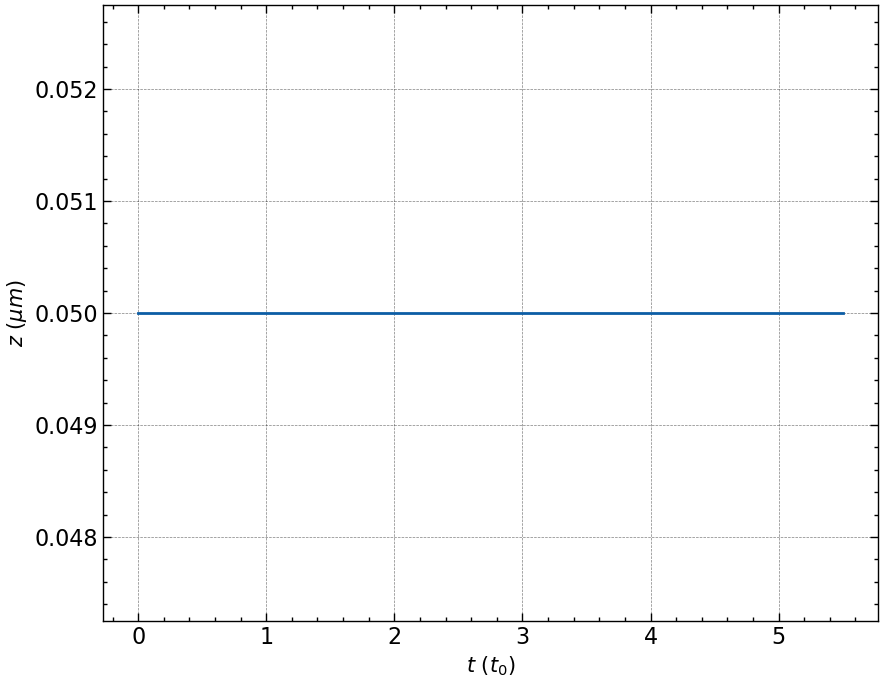

In [39]:
plt.style.use(['science', 'notebook', 'grid'])

x = sol.y[0]; y = sol.y[1]; z = sol.y[2]
fig = plt.figure(figsize = (10, 8))
plt.plot(t, sol.y[2])

plt.xlabel('$t \ (t_0)$', fontsize = 15)
plt.ylabel('$z \ (\mu m)$', fontsize = 15)

#plt.savefig('HG_zt.png', dpi=200)

plt.show()

C:\Users\HP_USER\AppData\Local\Temp\ipykernel_11052\3818672216.py:11: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(x.min(), x.max())
C:\Users\HP_USER\AppData\Local\Temp\ipykernel_11052\3818672216.py:12: UserWarning: Attempting to set identical bottom == top == -5.0 results in singular transformations; automatically expanding.
  ax.set_ylim(y.min(), y.max())
C:\Users\HP_USER\AppData\Local\Temp\ipykernel_11052\3818672216.py:13: UserWarning: Attempting to set identical bottom == top == 0.05 results in singular transformations; automatically expanding.
  ax.set_zlim(z.min(), z.max())


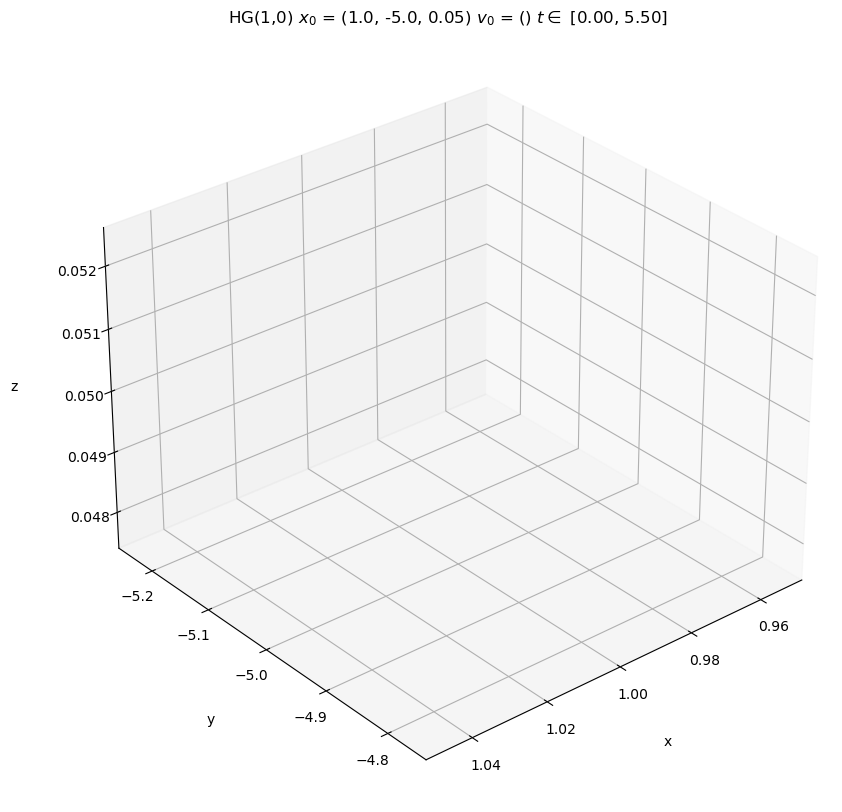

In [36]:
plt.style.use(['default'])

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize = (10, 10))

ax.plot3D(x, y, z.min())

ax.plot3D(x, y, z, "r", markersize=5)

ax.set_title('HG({:},{:}) $x_0$ = {:} $v_0$ = {:} $t \in$ [{:.2f}, {:.2f}]'.format(m, p, S_0[:3], S_0[3:], t0, tf))
        
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_zlim(z.min(), z.max())

ax.set_xlabel("x", labelpad = 20)
ax.set_ylabel("y", labelpad = 20)
ax.set_zlabel("z", labelpad = 20)

ax.view_init(elev=30, azim=50)

#plt.savefig('HG_3d.png', dpi=200)
plt.show()